In this practical we will implement multiclass classification with classic Logistic Regression, Multilayer Perceptron, and the convolutional neural network LeNet5 on image data. We will compare the performance of these models. You will work on the following:

 1. Imports and Hardware check
 2. Loading data and related transformations 
 3. Defining training helper functions and metrics 
 4. Logistic Regression 
 5. MLP
 6. CNN
 7. Comparison of results across models

We'll be storing all the losses and accuracies while training, and plotting everything in the end. Use `tqdm` to keep track of your training and validation losses and accuracies since we're only plotting them in the end.

In [42]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchsummary


torch.manual_seed(42) # Set manual seed

In [43]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cpu


## Define data transformations

We will work with the CIFAR-10 dataset, an established computer vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The goal of this dataset is to predict the image class.

Note: The constants in `transforms.Normalize()` are the means and standard deviations of the three color channels of the images in the CIFAR-10 training set. You can verify these numbers yourself by re-computing them.

In [44]:
batch_size = 256

train_transforms = transforms.Compose([ #Compose simply allows us to group multiple transformation operations together
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transforms = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [45]:
# Load the data and transform the dataset
train_dataset =  datasets.CIFAR10(root='./data', train=True, download=True, transform= train_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform= test_transforms)

# You can verify the mean and standard deviation used in the normalization above by calculating the mean and std of the training dataset above. 
verify_transform = transforms.Compose([transforms.ToTensor()]) # We dont want to have the other transformations, to assess the raw RGB Values.
train_verification_dataset = datasets.CIFAR10(root='./data', train = True, download = True, transform = verify_transform)

def compute_mean_std(Dataloader):
    #Initialize mean and std
    mean = 0.0 
    std = 0.0 
    #to divide by total amount of images later on
    total_images_count = 0
    
    for imgs, _ in Dataloader: #the _ indicates we ignore something, which here is equivalent to the labels of the images
        imgs = imgs.view(imgs.size(0), imgs.size(1), -1) #reshapes every image into a 2D tensor, i.e. from (channels, height, widht) to (channels, height*width)
        #size(0) = batch size, size(1) = number of channels, e.g. 3 for RGB, size(2) = height of img, size(3) = width of img
    
        '''
        imgs so far is a tensor of shape (batch_size, channels, height*width). The .mean and .std
        below use the third dimension, i.e. height*width, i.e. the pixels, for calculation. This results
        in a tensor of shape (batch_size, channels), where each element (i,j) represents the mean value
        of image i in channel j. Then, by sum(0), all these values are summed up by the first dimension,
        i.e. the batch_size, resulting in a tensor of shape (3,) where each element is the sum of all mean
        values of a channel across the entire batch.
        
        '''    
        
        mean += imgs.mean(2).sum(0) #gets the mean over the pixel dimension, ie. height*width 
        std += imgs.std(2).sum(0) #gets the std over the pixel dimension, ie. height*width
        total_images_count += imgs.size(0) #track total amount of pictures
    
    #calculate mean and std
    mean /= total_images_count
    std /= total_images_count

    return mean, std

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [46]:
# TODO: make dataloaders (from torch.utils) from datasets, define batch size and do not forget shuffling 
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#To verify the mean and std used above
verify_loader = DataLoader(train_verification_dataset, batch_size = batch_size, shuffle = True)
mean_ver, std_ver = compute_mean_std(verify_loader)
print(mean_ver, std_ver)
 

tensor([0.4914, 0.4822, 0.4465]) tensor([0.2023, 0.1994, 0.2010])


In [47]:
def show_batch(dl, batch_idx, num_plots): #dl = dataloader, number of plots to not always plot every thing
    '''
    a dataloader looks roughly like this: batch_index, (data, labels)
    To plot its contents then, we must go through it by using the batch_index, and grab
    the data and label as pairs. We can test this with the code commented out below: 
    '''
    '''
    for batch_idx, (data, labels) in enumerate(dl):
        print(f"Batch {batch_idx + 1}:")
        print("Data shape:", data.shape) #data shape yields (256, 3, 32, 32)
        print("Labels shape:", labels.shape) #labels shape yields ([256])
        break #break so we dont print every batch
    '''
    if num_plots < 0:
        raise ValueError("Number of plots cannot be negative")
        
    plt.figure(figsize=(50,50))
    
    for i, batch in enumerate(dl):
        if (i == batch_idx):
            
            images, labels = batch #images has shape (256, 3, 32, 32), i.e. 256 images, i.e. is the batch_data
            j = 0 #check if we reach the wanted number of subplots
            
            if num_plots > len(images):
                num_plots = len(images) #we use this to ensure that we draw at most the entire batch
            
            from math import sqrt, ceil #to create subplot grid of optimal size (dimensions)
            grid_dim = ceil(sqrt(num_plots))

            k = 1 #index for subplot
            
            #set the fontsize in best effort approach:
            if (num_plots <= 25):
                fontsize = 75
            elif (num_plots <= 100):
                fontsize = 50
            elif (num_plots <= 256):
                fontsize = 40
            else: fontsize = 0
                
            for image, label in zip(images, labels):
                #subplot related
                plt.subplot(grid_dim,grid_dim,k) #subplot creates a grid of nrwos*ncols, so e.g. 10,10 would create a grid of 10*10 = 100 subplots at most
                k += 1 #increase
                
                # the single image 
                image = image.permute(1,2,0) # this sets the channels to be the last dimension: (widht, height, channels)
                plt.imshow(image)
                plt.axis('off')
                
                #setting a best effort fontsize
                #grid_size*grid_size/num_plots is the space of every image
                plt.title(train_dataset.classes[label.item()], fontsize=fontsize)
                j += 1
                if (j >= num_plots): break
            
            break #once we went through the if statement, we can stop, as we intent to show only one batch
    plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

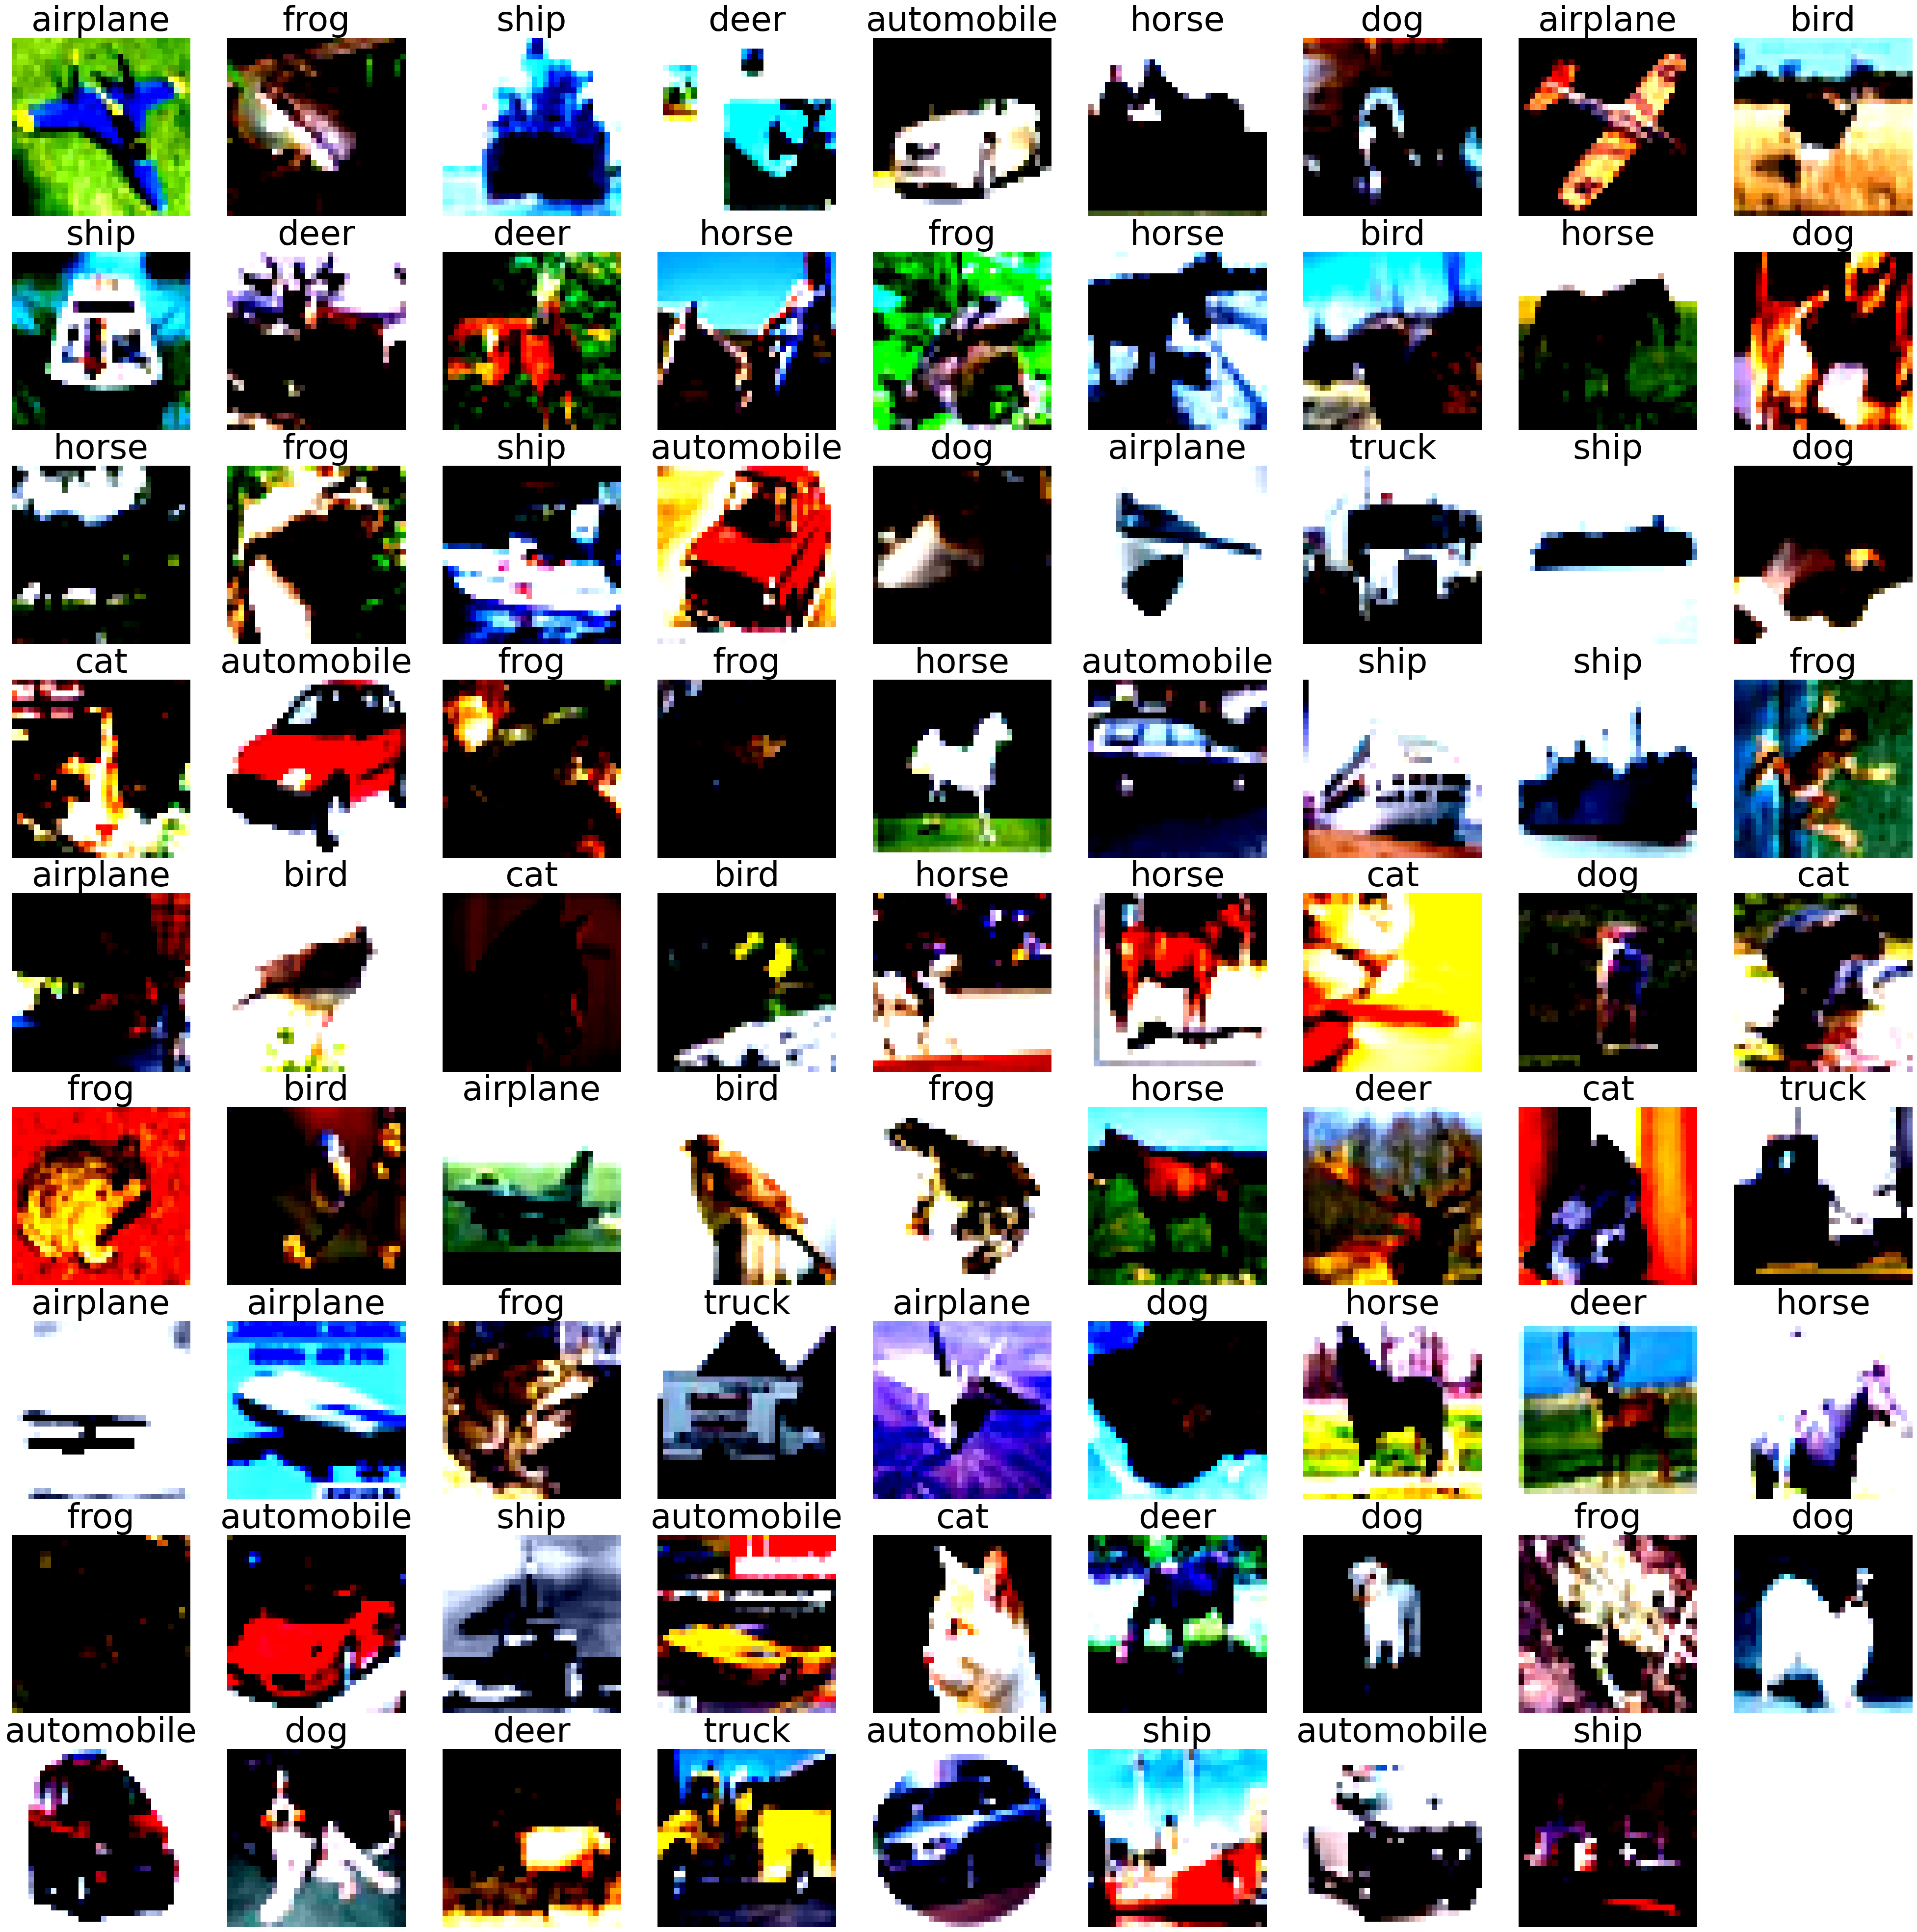

In [48]:
#General variables
dataloader = train_loader
batch_size = dataloader.batch_size

#for the show_batch method
from random import randint
batch_idx = randint(0, batch_size-1)
num_plots = batch_size

#method call
show_batch(dataloader, batch_idx, num_plots)

In [49]:
num_classes = 10

## Define helper functions for training and metrics

You will need these again and again. 

In [50]:
## TODO: write a function that calculates the accuracy

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    acc = correct/total

    return acc

In [51]:
## TODO: Define a train and validation functions here
## Hint - you can use yours from Practical 2 


def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """ method to train the model """
        # TODO: refine the training function from above
  # it should contain:
  # - saving of losses
  # - calculation of accuracy
  # - returning the mean loss and accuracy
    
    train_losses = 0.0
    correct_predictions = 0
    total_predictions = 0
    model.train()
    for i, (inputs, labels) in enumerate(dataloader):
        optimizer.zero_grad()

        #Forward pass
        prediction = model.forward(inputs)
        #print(prediction[0,:])
        loss = loss_fn(prediction, labels)
        train_losses += loss.item()

        #Calculate accuracy
        max_value, index_max_value = torch.max(prediction,1)
        correct_predictions += torch.eq(index_max_value,labels).sum().item()
        total_predictions += inputs.size(0)

        #Backward pass
        loss.backward()
        optimizer.step()

    acc = accuracy(correct_predictions, total_predictions)
    train_losses = train_losses/len(dataloader)

    return train_losses, acc
        



def validate(dataloader, model, loss_fn, device, master_bar):
    """ method to compute the metrics on the validation set """
    # TODO: write a validation function that calculates the loss and accuracy on the validation set
    # you can also combine it with the training function

    val_losses = 0.0
    correct_predictions = 0
    total_predictions = 0
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            predictions = model.forward(inputs)
            loss = loss_fn(predictions, labels)
            val_losses += loss.item()
            
            #Calculate accuracy
            max_value, index_max_value = torch.max(predictions,1)
            correct_predictions += torch.eq(index_max_value,labels).sum().item()
            total_predictions += inputs.size(0)

    val_losses = val_losses/len(dataloader)
    acc = accuracy(correct_predictions, total_predictions)
    return val_losses, acc
  
    

In [52]:
#TODO: write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from Practical 2 
from tqdm import trange


def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
    # TODO: write a run_training function that 
  # - calls the train and validate functions for each epoch
  # - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    # Reset model
    for param in model.parameters():
        if param.requires_grad:
            param.data.uniform_(-0.1, 0.1)
    
    master_bar = trange(num_epochs, desc="Epoch", unit="epoch")


    for epoch in master_bar:
        #Train
        train_loss, train_acc = train(train_dataloader, optimizer, model, loss_function, device, master_bar)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_loss, val_acc = validate(val_dataloader, model, loss_function, device, master_bar)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print("Epoch done")
    
    return train_losses, train_accs, val_losses, val_accs

In [53]:
# TODO: write a function to calculate and return the confusion values

from sklearn.metrics import confusion_matrix

def calc_confusion_values(dataloader, model, device):
    """ method to compute the confusion values on the validation set """
    y_pred = []
    y_true = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            predictions = model(inputs)
            predictions = predictions
            #print(predictions)
            _, predicted = torch.max(predictions, 1)

            #print(predicted)
            y_pred.extend(predicted)
            y_true.extend(labels.numpy())


    """
        torch.max returns two tensors, of which we ignore the first one
        the second has the shape [batch_size] and contains the index for each outputs dimension, for
        which the value is maximal in that dimension.
        E.g. let:
        outputs = torch.tensor([[1.2, 2.3, 0.7, 0.8],
                                [0.5, 1.1, 2.2, 1.8],
                                [1.9, 0.6, 2.0, 0.4]])
        then let
        predicted = torch.tensor([1, 2, 2])
        This would mean that in the first dimension of outputs, the max value is at index 1, here: 2.3,
        in the second dimension at index 2, here: 2.2, and in the third dimension at index 2, here: 2.0

        So, this is representative of what our model predicts the highest value for, or, put differently,
        what our model thinks is the most likely label for the given input. Again put differently, this
        is what our model thinks the image it saw represented.
     """
    #classes=("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck")

    #Build confusion matrix
    #print(y_pred)
    #print(y_true)
    
    cf_matrix = confusion_matrix(y_true,y_pred)
    
    return cf_matrix

## Logistic Regression   

In [54]:
# TODO: define logistic regression model class and its necessary functions
# What are the dimensions of your input layer?
# TODO: flatten the input to a suitable size for the initial layer
class LogisticRegression(torch.nn.Module):
    # same as linear regression model from practical 2 bc both use linear model
    # difference is in activation function and loss function
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, input_dim)
        outputs = self.linear(x)

        return outputs
    

In [55]:
train_batch, label_batch = next(iter(train_loader))

In [56]:
train_batch.shape

torch.Size([256, 3, 32, 32])

In [57]:
input_dim = np.prod(train_batch[0].shape) # product 
output_dim = len(train_dataset.classes) # number of the classes

In [58]:
input_dim

3072

In [59]:
## TODO : Define network, put it to the device and train mode
logistic_regression = LogisticRegression(input_dim, output_dim)

# Moooove
logistic_regression.to(device)

# Traiiiin
logistic_regression.train()

LogisticRegression(
  (linear): Linear(in_features=3072, out_features=10, bias=True)
)

In [60]:
## Optimizer defined. We're going to use Adam since it's always the safe bet, and also for faster convergence. 
optimizer = torch.optim.Adam(logistic_regression.parameters(), lr=0.001)

### Define loss 

Since we're dealing with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in \[0, 1\] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.

Hint: Due to numerical reasons, softmax and cross entropy are combined into one operation. Read more about it in https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [61]:
# TODO: define the loss function
loss_fn = nn.CrossEntropyLoss()

In [62]:
num_epochs = 20

In [63]:

## TODO: run training over 20 epochs
logreg_train_losses, logreg_train_accs, logreg_val_losses, logreg_val_accs = run_training(
    logistic_regression, optimizer, loss_fn, device, num_epochs, train_loader, val_loader
)

Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done


Epoch: 100%|██████████| 20/20 [15:00<00:00, 45.05s/epoch]


In [64]:
logreg_val_losses

[2.104472300410271,
 2.075159865617752,
 1.9484633564949037,
 1.9154071807861328,
 1.8748887330293655,
 1.914300063252449,
 1.8381789743900299,
 1.9021660000085832,
 1.8581241905689239,
 1.8524942696094513,
 1.8775369018316268,
 1.9062508642673492,
 1.89166020154953,
 1.84896340072155,
 1.8382750391960143,
 1.8867947787046433,
 1.8861871540546418,
 1.8376844644546508,
 1.8422000885009766,
 1.8374425292015075]

## Multilayer Perceptron

MLP is a network which consists of several linear fully-connected layers with non-linearities between them.

### Question:
Why are non-linearities between linear layers important?

#### Answer:
Non-linearities between linear layers are important for several reasons. In this context the most important one, is that they allow a hierarchical feature extraction. This means that in the prosess of labeling the images not all layers do the same, for example the first layer detect edges, while higher layers detect shapes or objects.

In [65]:
## TODO: Make the 4 layer MLP  with the following shapes :
## input_dim -> 2048 -> 512 -> 128 -> output_dim
## Use RELu as nonlinearity
## In the forward pass do not forget to flatten the input
class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self,input_dim,output_dim):
            super().__init__()
            self.linear1 = torch.nn.Linear(input_dim,2048)
            self.linear2 = torch.nn.Linear(2048,512)
            self.linear3 = torch.nn.Linear(512,128)
            self.linear4 = torch.nn.Linear(128,output_dim)
            self.relu = torch.nn.ReLU()
        
    def forward(self,x):
        x = torch.flatten(x,1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        return x

In [66]:
## TODO: Define network, put it to device and train mode
multilayerperceptron = MultiLayerPerceptron(input_dim,output_dim)
multilayerperceptron.to(device)
multilayerperceptron.train()

MultiLayerPerceptron(
  (linear1): Linear(in_features=3072, out_features=2048, bias=True)
  (linear2): Linear(in_features=2048, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

In [67]:
## TODO: Define optimizer and loss functions
optimizer = torch.optim.Adam(multilayerperceptron.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [68]:
## TODO: Train the MLP over 20 epochs
mlp_train_losses, mlp_train_accs, mlp_val_losses, mlp_val_accs = run_training(
    multilayerperceptron, optimizer, loss_fn, device, num_epochs, train_loader, val_loader)

Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done


Epoch: 100%|██████████| 20/20 [39:40<00:00, 119.03s/epoch]


In [69]:
mlp_val_accs

[0.4359,
 0.466,
 0.5052,
 0.5146,
 0.5229,
 0.5406,
 0.5317,
 0.5256,
 0.5466,
 0.5478,
 0.5489,
 0.5403,
 0.5479,
 0.5433,
 0.5479,
 0.558,
 0.5705,
 0.5618,
 0.5477,
 0.5634]

## Add L2 regularisation

In [70]:

# TODO: Define new model, optimizer, put model to device, etc.
## 0.00005 is a good starting point for the regularization strength
class MultiLayerPerceptronL2(torch.nn.Module):
    def __init__(self,input_dim,output_dim, l2):
            super().__init__()
            self.linear1 = torch.nn.Linear(input_dim,2048)
            self.linear2 = torch.nn.Linear(2048,512)
            self.linear3 = torch.nn.Linear(512,128)
            self.linear4 = torch.nn.Linear(128,output_dim)
            self.relu = torch.nn.ReLU()
            self.l2 = l2
        
    def forward(self,x):
        x = torch.flatten(x,1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        return x
    
    def get_l2_loss(self):
        #  include the L2 in the loss function
        l2_loss = 0
        for param in self.parameters():
            # sum up squared value of weights 
            l2_loss += torch.sum(param ** 2)
        # scale squared values with l2 factor
        return self.l2 * l2_loss

In [71]:
## TODO: Retrain new model with regularization over 20 epochs

# Set l2 strength
l2_strength = 0.00005

# Model instance
MLPL2 = MultiLayerPerceptronL2(input_dim, output_dim, l2_strength)

# Train modus
MLPL2.train()

# Wieder Adam
optimizer = torch.optim.Adam(MLPL2.parameters(), lr=0.001)

# Loss function wieder crossentropy aber diesmal mit regularisierung
def loss_fn(data,label):
    return torch.nn.CrossEntropyLoss()(data, label) + MLPL2.get_l2_loss()

In [72]:
mlpl2_train_losses, mlpl2_train_accs, mlpl2_val_losses, mlpl2_val_accs = run_training(
    MLPL2, optimizer, loss_fn, device, num_epochs, train_loader, val_loader)

Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done


Epoch: 100%|██████████| 20/20 [42:28<00:00, 127.41s/epoch]


In [73]:
mlpl2_val_accs

[0.4492,
 0.4854,
 0.4903,
 0.4984,
 0.5178,
 0.5229,
 0.5351,
 0.5436,
 0.536,
 0.5189,
 0.5404,
 0.5445,
 0.5569,
 0.5564,
 0.5437,
 0.5538,
 0.556,
 0.5376,
 0.5578,
 0.5558]

## LeNet5

Let's implememt one of the classical convolutional network and apply it for CIFAR-10. Here is the link for the [original paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) of LeNet5 introduced by Yann LeCun and colleagues in 1998. The original implementation of LeNet5 has Tanh as nonlinearities. In 2012, AlexNet famously set off the deep learning revolution. AlexNet is based on LeNet, with two main innovations: (1) making it deeper by adding a few extra layers and (2) replacing the tanh activation functions by ReLU to improve training. Here we'll the original LeNet5 architecture to keep the compute requirements small, but work with the more modern ReLU activation functions.

One more thing we change in the original network is the number of input channels as LeNet5 was designed for grayscale MNIST dataset, where each picture has 1 channel, while for RGB pictures we have 3 channels in the input data.

In [74]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, in_channels=1):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU(),
            ## TODO: add remaining layers, pooling and nonlinearities up to layer C5
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes)
            ## TODO: add ReLU nonlinearity and final classification linear layer
    
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [75]:
## TODO: define network, put it to the device and train mode
lenet5 = LeNet5(n_classes=10, in_channels=3)
lenet5.to(device)
lenet5.train()

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

For a quick overview of models, torchsummary.summary is quite helpful  
comment: You can also import predefined architectures from `torchvision` and run `torchsummary.summary` on them to get a quick overview

In [76]:
## TODO: run torchsummary.summary on the LeNet5 and your MLP model. What do you see?
torchsummary.summary(MLPL2, input_size=(3,32,32))
torchsummary.summary(lenet5, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
              ReLU-2                 [-1, 2048]               0
            Linear-3                  [-1, 512]       1,049,088
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 128]          65,664
              ReLU-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 7,409,546
Trainable params: 7,409,546
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 28.27
Estimated Total Size (MB): 28.32
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               

In [77]:
## TODO: define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.001)

In [78]:
## TODO: train with 20 epochs
num_epochs = 20

lenet5_train_losses, lenet5_train_accs, lenet5_val_losses, lenet5_val_accs = run_training(
    lenet5, optimizer, loss_fn, device, num_epochs, train_loader, val_loader)

Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done
Epoch done


Epoch: 100%|██████████| 20/20 [22:11<00:00, 66.57s/epoch]


In [79]:
lenet5_val_losses

[1.5775585919618607,
 1.4247971951961518,
 1.3659902334213256,
 1.3144506841897965,
 1.2350182384252548,
 1.208261276781559,
 1.1949715942144394,
 1.1801349595189095,
 1.1361784562468529,
 1.0997384756803512,
 1.0841635763645172,
 1.0859599441289902,
 1.0675725966691971,
 1.0726765900850297,
 1.0722510114312171,
 1.029669526219368,
 1.0127275347709657,
 1.0276995792984962,
 1.021534052491188,
 1.0062679678201676]

## Analysis 

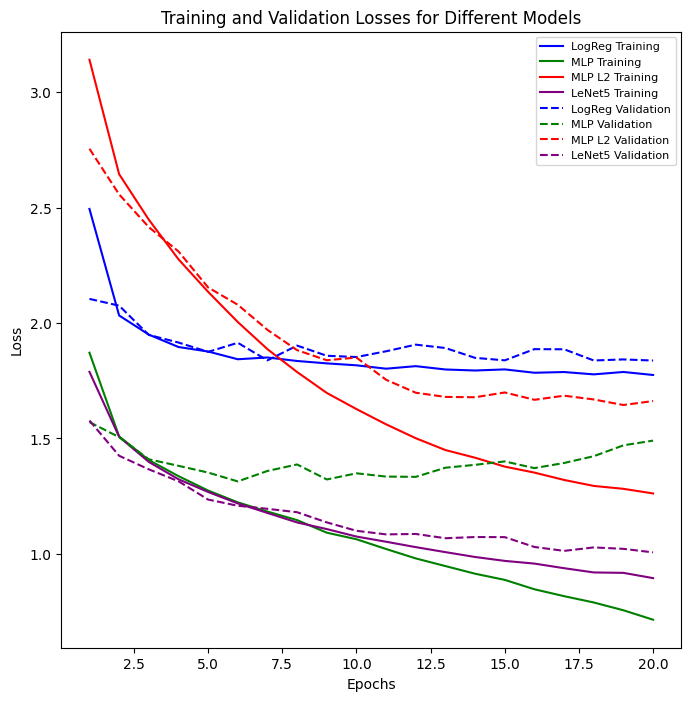

In [80]:
## TODO: Plot both train and val losses for all models. 
## What do you see?
plt.figure(figsize=(8, 8))
x = np.arange(1,21)

# Plot training losses
plt.plot(x, logreg_train_losses, label='LogReg Training', color='blue')
plt.plot(x, mlp_train_losses, label='MLP Training', color='green')
plt.plot(x, mlpl2_train_losses, label='MLP L2 Training', color='red')
plt.plot(x, lenet5_train_losses, label='LeNet5 Training', color='purple')

# Plot validation losses
plt.plot(x, logreg_val_losses, '--', label='LogReg Validation', color='blue')
plt.plot(x, mlp_val_losses, '--', label='MLP Validation', color='green')
plt.plot(x, mlpl2_val_losses, '--', label='MLP L2 Validation', color='red')
plt.plot(x, lenet5_val_losses, '--', label='LeNet5 Validation', color='purple')

# Adding titles and labels
plt.title('Training and Validation Losses for Different Models')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize=8)

# Show plot
plt.show()

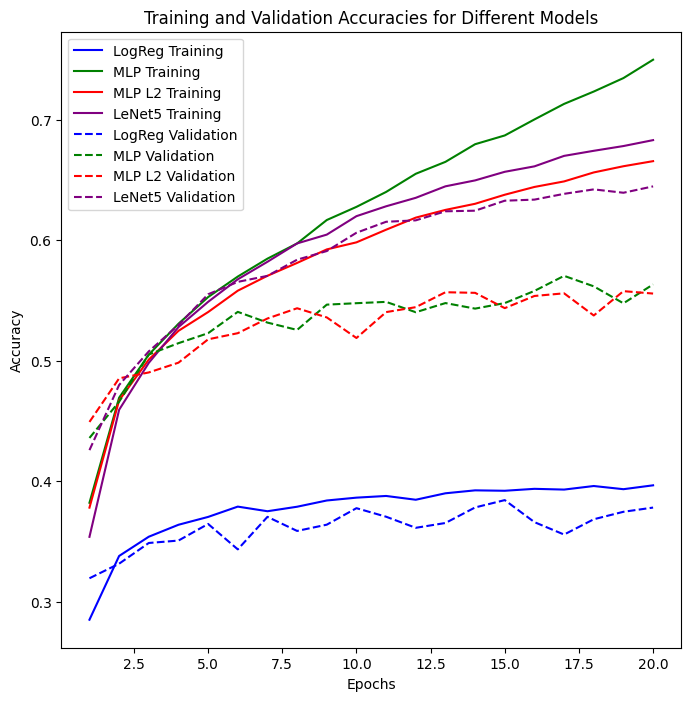

In [81]:
## TODO: Plot both train and val accuracies for all models. 
## What do you see?
plt.figure(figsize=(8, 8))
x = np.arange(1,21)

# Plot training losses
plt.plot(x, logreg_train_accs, label='LogReg Training', color='blue')
plt.plot(x, mlp_train_accs, label='MLP Training', color='green')
plt.plot(x, mlpl2_train_accs, label='MLP L2 Training', color='red')
plt.plot(x, lenet5_train_accs, label='LeNet5 Training', color='purple')

# Plot validation losses
plt.plot(x, logreg_val_accs, '--', label='LogReg Validation', color='blue')
plt.plot(x, mlp_val_accs, '--', label='MLP Validation', color='green')
plt.plot(x, mlpl2_val_accs, '--', label='MLP L2 Validation', color='red')
plt.plot(x, lenet5_val_accs, '--', label='LeNet5 Validation', color='purple')

# Adding titles and labels
plt.title('Training and Validation Accuracies for Different Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show plot
plt.show()

In [82]:
## TODO: Plot the confusion matrix for LeNet5
cfmatrix = calc_confusion_values(val_loader, lenet5, device)
cfmatrix

# Row shows true class, Column shows predicted class

array([[690, 23, 70, 27, 16, 22, 14, 6, 75, 57],
 [ 32, 749, 17, 15, 9, 8, 24, 2, 30, 114],
 [ 67, 8, 520, 66, 109, 99, 80, 22, 16, 13],
 [ 19, 9, 77, 427, 82, 226, 87, 27, 17, 29],
 [ 20, 5, 102, 49, 592, 67, 88, 49, 18, 10],
 [ 16, 4, 53, 173, 57, 584, 41, 46, 8, 18],
 [ 12, 12, 45, 51, 33, 28, 800, 4, 7, 8],
 [ 16, 5, 40, 57, 108, 114, 16, 603, 5, 36],
 [102, 35, 18, 21, 8, 21, 12, 5, 748, 30],
 [ 33, 105, 13, 25, 8, 16, 18, 10, 37, 735]])

## Questions
* How did regularization change the performance of the MLP? Why?

Answer: 

After the regularization, the accuracy of the training and validation dataset were more alike. Also, the training data did not reach such a high accuracy anymore. In regard to the losses, you see the same behaviour. So the losses for the training and validation are more similar for the MLP with the regularisation. But also they are higher. 
The reason for these changes is that the L2 regularization is to prevent overfitting. It does this by adding a penalty to the loss function of the model, which is proportional to the sum of the squared values of the weights. This encourages the model to keep the weights small, leading to a simpler model that is less likely to overfit. Therefore, our model does not fit our training data as good as without the regularization, but it can fit the validation set in a similar good way.

* Explain the confusion matrix for LeNet5. What do you see there?

Answer: 

The contribution of the i-th row and j-th column of the matrix indicates how often a label of number i was predicted as one of number j. The main diagonal of the matrix therefore contains the values that a label was correctly assigned. If the matrix only had entries in the main diagonal, the predictions of the model would be perfect. We can also see with which other categories the images were mainly confused. For example, category 3 was often confused with category 5 and vice versa. It is therefore difficult for the model to distinguish between these two categories.


* Explain the difference in performance between linear regression, MLP, and LeNet5.

Answer: 

In general but also in comparison to the other models, the linear regression performed very poorly with a training and validation accuracy of below 0.4. The MLP performed better, both with and without L2 regularization. However, it should be noted that the high training accuracy of up to around 0.65 without L2 and 0.75 with L2 could only be observed on the training data. In the validation, the MLP models both seemed to perform worse with a similar accuracy of up to 0.55. At last, the LeNet5 proved to be the best performing. Here, the validation accuracy was not too far from the training accuracy, which was an issue with the MLP models. 

These differences can be explained by the complexity of the models. The linear regression is a rather simple model, in principle it is able to learn to label the images, but only with a lot of training. The MLP has multiple layers. This helps the model to find the wright label in a more efficient way because the multiple layers can be used to detect different parts of the images, like edges. The LeNet5 model is a convolutional network. This means that the model has convolutional layers. Therefore, there are three mechanisms which help with image recognition: local receptive fields, weight sharing and subsampling. These mechanisms help to recognise the image, even if it is shifted or rotated.  



* Why are convolutions better suited for pictures? Which properties of images do they exploit?

Answer: 

There are several reasons why convolutions are suited for pictures. First, they are locally connected. This helps to identify a picture because pictures often contain local features like edges, which are important to recognise the whole picture. The second mechanism is weight sharing. This helps to find repetitive structures. Third, convolutions can be applied in a hierarchical manner. This helps to identify the various information of an image, which differ in their complexity, e.g. there are details and bigger structures. And last, convolutions can help to detect translated structures in images, like when it is rotated or shifted. 


* Is it important to redefine an optimizer for each different model, training? What about loss functions?
  
Answer: 

I am honestly not sure how to understand this question. If it is about redefining the optimizer for each new model (e.g. for Logistic Regression, for MLP, for LeNet, etc.), then the answer is yes. We have to pass the optimizer the parameters of the model we want to optimize, so if we decide to train a different model, we need to pass the parameters of that different model to the optimizer. On the other hand, if this question asks if we need to redefine the optimizer in each training iteration, the answer is no. The optimizer can be used across all training iterations without redefinition. Regarding the loss function: As we do not have to pass the specific model, we do not need to redefine the loss function if both models use the same one. We only need to redefine if a different one is used. For example, when we added the L2 term to the MLP's CrossEntropyLoss.